In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# GAN Proof of concept

%matplotlib inline


def cost_generator(Y, A):
    return -np.sum((1 - Y)*np.log(np.where(A > 0, A, 0.1)))/len(Y)


def grad_generator(Y, A):
    # compute cost function
    # -Y/A * A(1 - A)
    return -(1 - Y)*(1 - A)


def cost_descriminator(Y, A):
    return -np.sum(Y*np.log(np.where(A > 0, A, 0.1)) +
                   (1 - Y)*np.log(1-np.where(A < 1, A, 0.9)))/len(Y)
    

def grad_descriminator(Y, A):
    # compute cost
    # (-Y(1-A) + (1-Y)A)/A(1 - A) * A(1 - A)
    return A - Y


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def propagate_descriminator(descriminator, X, Y):
    m = len(Y)
    # forward pass
    z = np.matmul(descriminator['W'], X) + descriminator['b']
    a = sigmoid(z)
    # backprob
    dz = grad_descriminator(Y, a)
    dw = np.matmul(dz, X.T)/m
    db = np.sum(dz, axis=1)/m
    return {'dW': dw, 'db': db,
            'cost': cost_descriminator(Y, a)}


def propagate_generator(generator, descriminator, X, Y):
    m = len(Y)
    # forward pass
    z1 = np.matmul(generator['W1'], X) +  generator['b1']
    a1 = sigmoid(z1)
    z2 = np.matmul(generator['W2'], a1) + generator['b2']
    a2 = sigmoid(z2)
    # Run Forward pass of discriminator
    z3 = np.matmul(descriminator['W'], a2) + descriminator['b']
    a3 = sigmoid(z3)
    # backward pass
    dz3 = grad_generator(Y, a3)
    da2 = np.matmul(descriminator['W'].T, dz3)
    dz2 = da2 * (1 - da2)
    dw2 = np.matmul(dz2, a1.T)/m
    db2 = np.sum(dz2, axis=1).reshape(-1, 1)/m
    da1 = np.matmul(generator['W2'].T, dz2)
    dz1 = da1 * (1 - da1)
    dw1 = np.matmul(dz1, X.T)/m
    db1 = np.sum(dz1, axis=1).reshape(-1, 1)/m
    return {'dW1': dw1, 'db1': db1,
            'dW2': dw2, 'db2': db2,
            'cost': cost_generator(Y, a3)}


def generate(generator, X):
    z1 = np.matmul(generator['W1'], X) +  generator['b1']
    a1 = sigmoid(z1)
    z2 = np.matmul(generator['W2'], a1) + generator['b2']
    return sigmoid(z2)


def generate_discriminator_data(generator, noise, real_data,
                                label_real, label_fake,
                                shuffle):
    # Turn Noise into fake data by calling generator
    fake_data = generate(generator, noise)
    data = np.concatenate((real_data,
                           generate(generator, noise)),
                          axis=1)
    labels = np.concatenate((label_real, label_fake), axis=1)
    return data[:, shuffle], labels[:, shuffle]


def train(generator, descriminator, alpha, iterations, data, noise):
    
    _, m = data.shape
    label_real = np.ones((1, m))
    label_fake = np.zeros((1, m))
    shuffle = np.random.permutation(m*2)

    for i in range(iterations):
        # generate data for discriminator
        d_data, g_labels = generate_discriminator_data(generator, noise, data,
                                                       label_real, label_fake,
                                                       shuffle)
        
        grad_descriminator = propagate_descriminator(descriminator,
                                                     d_data,
                                                     g_labels)
        # generator trains with noise
        grad_generator = propagate_generator(generator,
                                             descriminator,
                                             noise,
                                             label_fake)
        
        # update discriminator
        descriminator['W'] -= alpha*grad_descriminator['dW']
        descriminator['b'] -= alpha*grad_descriminator['db']
        descriminator['cost'][i] = grad_descriminator['cost']
        # update generator
        generator['W1'] -= alpha*grad_generator['dW1']
        generator['b1'] -= alpha*grad_generator['db1']
        generator['W2'] -= alpha*grad_generator['dW2']
        generator['b2'] -= alpha*grad_generator['db2']
        generator['cost'][i] = grad_generator['cost']

    return generator, descriminator


def loadimage(image_vector):
    n = 28
    plt.title('Noise')
    plt.imshow(image_vector.reshape(n, n),  cmap = 'gray')
    plt.show()


def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    
    # x_train = x_train[np.where(y_train == 5, True, False)]
    # x_test = x_test[np.where(y_test == 5, True, False)]
    
    m1, col1, row1 = x_train.shape
    n = col1 * row1
    m2, _, _ = x_test.shape

    data_train = x_train.reshape(-1, n).T/255
    data_test = x_test.reshape(-1, n).T/255
    
    noise_train = np.random.rand(10, m1)
    noise_test = np.random.rand(10, m2)

    return ((data_train, data_test),
            (noise_train, noise_test))


(784, 60000) (784, 10000)
(10, 60000) (10, 10000)


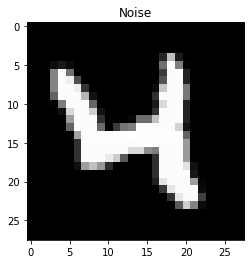

In [14]:
(data_train, data_test), (noise_train, noise_test) = load_data()
print(data_train.shape, data_test.shape)
print(noise_train.shape, noise_test.shape)

loadimage(data_train[:, 20])


/Users/juanpablogalazchavez/Class/Vision/env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


Done Training


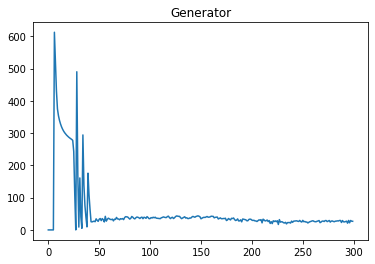

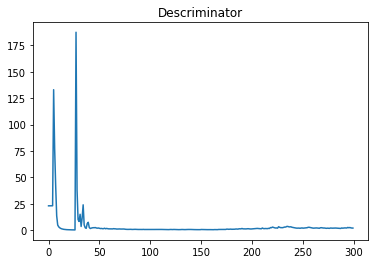

In [19]:
alpha = 0.01
iterations = 300
n, _ = data_train.shape
u = 250

num_samples = 10

descriminator = {'W': np.random.rand(1, n),
                 'b': 0,
                 'cost': np.zeros(iterations)}

generator = {'W1': np.random.rand(u, 10),
             'b1': np.random.rand(u, 1),
             'W2': np.random.rand(n, u),
             'b2': np.random.rand(n, 1),
             'cost': np.zeros(iterations)}

generator, descriminator = train(generator, descriminator,
                                 alpha, iterations,
                                 data_train[:, :num_samples],
                                 noise_train[:, :num_samples])
print('Done Training')
plt.title('Generator')
plt.plot(generator['cost'])
plt.show()

plt.title('Descriminator')
plt.plot(descriminator['cost'])
plt.show()

/Users/juanpablogalazchavez/Class/Vision/env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


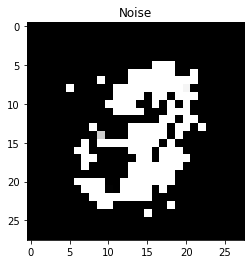

In [20]:
temp = noise_train[:, 60].reshape(-1, 1)
# Run Generator
generated_image = generate(generator, temp)
loadimage(generated_image)